# Integracja z Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
BASE_DIR = '/content/gdrive/My Drive/DL2020/Projekt2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Sieć konwolucyjna

## Konfiguracja wstępna

In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import time
import copy
import numpy as np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Ustawienie ziarna

In [0]:
seed = 0 #@param {type: "integer"}
torch.manual_seed(seed)
np.random.seed(seed)

## Konfiguracja sieci

In [0]:
#@title Wybór konfiguracji { run: "auto" }

config = "Wlasna konfiguracja 1" #@param ["Zmodyfikowany LeNet-5", "Wlasna konfiguracja 1", "Pretrained VGG16", "GoogLeNet"]

In [8]:
last_epoch = 0
last_loss = None

class Net(nn.Module):
    if config == "Zmodyfikowany LeNet-5":
        def __init__(self):
            super(Net, self).__init__()

            self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, stride = 1, kernel_size = 3, padding = 1)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, stride = 1, kernel_size = 3, padding = 1)
            self.relu2 = nn.ReLU()
            self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 1, kernel_size = 3, padding = 0)
            self.relu3 = nn.ReLU()
            self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.linear1 = nn.Linear(7 * 7 * 32, 300)
            self.relu4 = nn.ReLU()
            self.drop1 = nn.Dropout(p = 0.5)
            self.linear2 = nn.Linear(300, 10)

            self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2,
                                 self.maxpool1, self.conv3, self.relu3, self.maxpool2)
                                             
        def forward(self, x):
            x = self.net(x)
            x = x.view(-1, x.shape[0] , 7 * 7 * 32)
            x = self.linear1(x)
            x = self.relu4(x)
            x = self.drop1(x)
            x = self.linear2(x)
            return x

    elif config == "Wlasna konfiguracja 1":
        def __init__(self):
            super(Net, self).__init__()

            self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, stride = 1, kernel_size = 3, padding = 1)
            self.batchnorm1 = nn.BatchNorm2d(num_features = 16)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, stride = 1, kernel_size = 3, padding = 1)
            self.batchnorm2 = nn.BatchNorm2d(num_features = 32)
            self.relu2 = nn.ReLU()
            self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, stride = 1, kernel_size = 3, padding = 0)
            self.batchnorm3 = nn.BatchNorm2d(num_features = 64)
            self.relu3 = nn.ReLU()
            self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.linear1 = nn.Linear(7 * 7 * 64, 300)
            self.relu4 = nn.ReLU()
            self.drop1 = nn.Dropout(p = 0.5)
            self.linear2 = nn.Linear(300, 10)
            self.net = nn.Sequential(self.conv1, self.batchnorm1, self.relu1, self.conv2, self.batchnorm2, self.relu2,
                                 self.maxpool2, self.conv3, self.batchnorm3, self.relu3, self.maxpool3)
                                             
        def forward(self, x):
            x = self.net(x)
            x = x.view(-1, x.shape[0] , 7 * 7 * 64)
            x = self.linear1(x)
            x = self.relu4(x)
            x = self.drop1(x)
            x = self.linear2(x)
            return x

net = None
input_size = 32

if config == "Pretrained VGG16":
    def set_parameter_requires_grad(model):
        for param in model.parameters():
            param.requires_grad = False

    net = models.vgg16_bn(pretrained=True)
    set_parameter_requires_grad(net)
    num_ftrs = net.classifier[6].in_features
    net.classifier[6] = nn.Linear(num_ftrs, 10)
    net = net.to(device)
    input_size = 224
elif config == "GoogLeNet":
    net = models.googlenet(pretrained=True)
    #set_parameter_requires_grad(net)
    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, 10)
    net = net.to(device)
    input_size = 224
else:
    net = Net().to(device)

loss_array = []
acc_array = []
max_acc = 0

net

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=300, bias=True)
  (relu4): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=300, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride

In [9]:
from torchsummary import summary
summary(net, input_size=(3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
            Conv2d-2           [-1, 16, 32, 32]             448
       BatchNorm2d-3           [-1, 16, 32, 32]              32
       BatchNorm2d-4           [-1, 16, 32, 32]              32
              ReLU-5           [-1, 16, 32, 32]               0
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
            Conv2d-8           [-1, 32, 32, 32]           4,640
       BatchNorm2d-9           [-1, 32, 32, 32]              64
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
             ReLU-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
        MaxPool2d-14           [-1, 32,

### Kryterium i optymalizator

In [0]:
optimizer_type = "Adam" #@param ["SGD", "Adam"]
lr = 0.001 #@param {type: "number"}

criterion = nn.CrossEntropyLoss()

params_to_update = []
for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = None

if optimizer_type == "SGD":
    optimizer = optim.SGD(params_to_update, lr=lr, momentum=0.9)
if optimizer_type == "Adam":
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=0.002)

### Wczytanie stanu sieci (opcjonalne)

In [0]:
def load_net_state(path):
    if device == "cuda:0":
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    criterion.load_state_dict(checkpoint['criterion_state_dict'])
    last_epoch = checkpoint['epoch']
    last_loss = checkpoint['loss']
    loss_array = checkpoint['loss_array']
    acc_array = checkpoint['acc_array']
    if len(acc_array) > 0:
        max_acc = np.max(acc_array)
    else:
        max_acc = 0
    net.eval()
    return net, optimizer, criterion, last_epoch, loss_array, acc_array, max_acc

In [0]:
load_state = True #@param {type: "boolean"}
path = "wlasna_best_acc_8333_0.pt" #@param {type: "string"}

if load_state:
    net, optimizer, criterion, last_epoch, loss_array, acc_array, max_acc = load_net_state(BASE_DIR + path)


## Ustawienia augmentacji danych

In [0]:
#@title Metody augmentacji { run: "auto" }
translation_checkbox = False #@param {type:"boolean"}
flip_checkbox = True #@param {type:"boolean"}
rotation_checkbox = False #@param {type:"boolean"}
noise_checkbox = False #@param {type:"boolean"}
color_checkbox = True #@param {type:"boolean"}
crop_checkbox = False #@param {type:"boolean"}

In [0]:
transforms_array_train = []

if config == "Pretrained VGG16" or config == "GoogLeNet":
    transforms_array_train.append(transforms.Resize(size=(input_size, input_size)))

if crop_checkbox:
    transforms_array_train.append(transforms.RandomCrop(padding=None, size=(input_size, input_size)))
if translation_checkbox:
    transforms_array_train.append(transforms.RandomAffine(0, (0.2, 0.2)))
if flip_checkbox:
    transforms_array_train.append(transforms.RandomHorizontalFlip(p=0.5))
if rotation_checkbox:
    transforms_array_train.append(transforms.RandomRotation(degrees=(-15,15), resample=False, expand=False))
if color_checkbox:
    transforms_array_train.append(transforms.ColorJitter(brightness=[0.8,1.2], contrast=[0.8,1.2], saturation=[0.8,1.2]))
if noise_checkbox:
    transforms_array_train.append(AddGaussianNoise(0., 0.2))

transforms_array_train.append(transforms.ToTensor())
transforms_array_test = []

if config == "Pretrained VGG16" or config == "GoogLeNet":
    transforms_array_train.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]))
    transforms_array_test.append(transforms.Resize(size=(input_size, input_size)))
    transforms_array_test.append(transforms.ToTensor())
    transforms_array_test.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]))
else:
    transforms_array_train.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    transforms_array_test.append(transforms.ToTensor())
    transforms_array_test.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

## Wczytanie danych

In [12]:
transform_train = transforms.Compose(transforms_array_train)
transform_test = transforms.Compose(transforms_array_test)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified





  cat  ship  ship plane  frog  frog   car  frog   cat   car


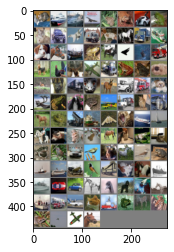

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

## Zapis stanu modelu

In [0]:
from datetime import datetime

def append_timestamp(path):
    now = datetime.now()
    current_time = now.strftime("%y.%m.%d_%H:%M:%S")
    return path.replace(".", f"_{current_time}.")

In [0]:
save_state = True #@param {type: "boolean"}
best_path = "komitet.pt" #@param {type: "string"}
use_timestamp = False #@param {type: "boolean"}

def save_model(path):
    if save_state:
        if use_timestamp:
            best_path = append_timestamp(path)
        torch.save({
                    'epoch': last_epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'criterion_state_dict': criterion.state_dict(),
                    'loss': last_loss,
                    'loss_array': loss_array,
                    'acc_array': acc_array
                    }, BASE_DIR + path)

## Uczenie sieci

In [0]:
def update_classify_table(classify_table, predictions, labels):
        for lab, pred in zip(labels, predictions):
            classify_table[lab, pred] += 1

def train_step(last_epoch):
    running_loss = 0.0
    for i, (img, label) in enumerate(trainloader):
        img = img.to(device)
        label = label.to(device)
        net.train()
        optimizer.zero_grad()
        prediction = net(img)
        loss = None
        if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
            loss = criterion(prediction[0], label)
        else:
            loss = criterion(prediction, label)
        loss.backward()
        optimizer.step()

        if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
            running_loss += loss.item()
        else:
            running_loss += loss.item() * img.size(0)
    return running_loss
    

def print_accuracy():
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        net.eval()
        classify_table = np.zeros((10,10))
        for i, (img, label) in enumerate(testloader):
            img = img.to(device)
            label = label.to(device)
            prediction = net(img)
            if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
                loss += criterion(prediction[0], label)
                _ , prediction = torch.max(prediction[0].data, 1)
            else:
                loss += criterion(prediction, label)
                _ , prediction = torch.max(prediction.data, 1)
            update_classify_table(classify_table, prediction, label.data)
            correct += torch.sum(prediction == label.data)

    accuracy = correct.cpu().numpy() / 10000
    print('Accuracy of the network on the 10000 test images: %.2f %%' % (
        100 * accuracy))   
    return accuracy

In [0]:
nb_epoch =  10#@param {type: "integer"}

In [0]:
counter = 0

for e in range(nb_epoch):
    last_epoch = last_epoch + 1
    running_loss = train_step(last_epoch)
    if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
        last_loss = running_loss / 500
    else:
        last_loss = running_loss / len(trainloader.dataset)
    print('%d epoch, loss: %.4f' % (last_epoch, last_loss))
    loss_array.append(last_loss)
    curr_acc = print_accuracy()
    acc_array.append(curr_acc)
    if curr_acc > max_acc:
        save_model(best_path)
        max_acc = curr_acc
        counter = 0
    else:
        counter = counter + 1
        if counter > 2:
            break

In [0]:
save_model(best_path)

### Wczytanie najlepszego stanu

In [0]:
load_best = True #@param {type: "boolean"}

In [0]:
if save_state and load_best:
    load_net_state(BASE_DIR + best_path)

## Komitet

### Budowa komitetu

In [0]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, modelC, modelD, modelE, modelF, modelG, modelH, modelI, modelJ, nb_classes=10):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE
        self.modelF = modelF
        self.modelG = modelG
        self.modelH = modelH
        self.modelI = modelI
        self.modelJ = modelJ
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x4 = self.modelD(x)
        x5 = self.modelE(x)
        x6 = self.modelF(x)
        x7 = self.modelG(x)
        x8 = self.modelH(x)
        x9 = self.modelI(x)
        x10 = self.modelJ(x)
        x = torch.stack((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10), dim=1)

        return x

In [0]:
modelA = Net().to(device)
checkpointA = torch.load((BASE_DIR + 'wlasna_best_acc_8333_0.pt'))
modelA.load_state_dict(checkpointA['model_state_dict'])

modelB = Net().to(device)
checkpointB = torch.load((BASE_DIR + 'wlasna_best_acc_8356_1.pt'))
modelB.load_state_dict(checkpointB['model_state_dict'])

modelC = Net().to(device)
checkpointC = torch.load((BASE_DIR + 'wlasna_best_acc_8310_2.pt'))
modelC.load_state_dict(checkpointC['model_state_dict'])

modelD = Net().to(device)
checkpointD = torch.load((BASE_DIR + 'wlasna_best_acc_8282_3.pt'))
modelD.load_state_dict(checkpointD['model_state_dict'])

modelE = Net().to(device)
checkpointE = torch.load((BASE_DIR + 'wlasna_best_acc_8359_4.pt'))
modelE.load_state_dict(checkpointE['model_state_dict'])

modelF = Net().to(device)
checkpointF = torch.load((BASE_DIR + 'wlasna_best_acc_8294_5.pt'))
modelF.load_state_dict(checkpointF['model_state_dict'])

modelG = Net().to(device)
checkpointG = torch.load((BASE_DIR + 'wlasna_best_acc_8279_6.pt'))
modelG.load_state_dict(checkpointG['model_state_dict'])

modelH = Net().to(device)
checkpointH = torch.load((BASE_DIR + 'wlasna_best_acc_8266_7.pt'))
modelH.load_state_dict(checkpointH['model_state_dict'])

modelI = Net().to(device)
checkpointI = torch.load((BASE_DIR + 'wlasna_best_acc_8307_8.pt'))
modelI.load_state_dict(checkpointI['model_state_dict'])

modelJ = Net().to(device)
checkpointJ = torch.load((BASE_DIR + 'wlasna_best_acc_8300_9.pt'))
modelJ.load_state_dict(checkpointJ['model_state_dict'])

model = MyEnsemble(modelA, modelB, modelC, modelD, modelE, modelF, modelG, modelH, modelI, modelJ).to(device)

### Wyniki dla komitetu

In [17]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    classify_table = np.zeros((10,10))
    for i, (img, label) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
        prediction = model(img)
        predictions = []
        for p in prediction[0]:
            _, curr_pred = torch.max(p.data, 1)
            predictions.append(curr_pred)
        prediction_list = []
        for j in range(100):
            tab = np.zeros(10)
            for k in range(10):
                tab[predictions[k][j]] = tab[predictions[k][j]] + 1
            prediction_list.append(tab.argmax())
        prediction = torch.FloatTensor(prediction_list).to(device)
        update_classify_table(classify_table, prediction_list, label.data)
        correct += torch.sum(prediction == label.data)

accuracy = correct.cpu().numpy() / 10000
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * accuracy)) 

Accuracy of the network on the 10000 test images: 85.13 %


## Wyniki

In [0]:
correct = 0
total = 0
loss = 0.0
with torch.no_grad():
    modelA.eval()
    classify_table = np.zeros((10,10))
    for i, (img, label) in enumerate(testloader):
        img = img.to(device)
        label = label.to(device)
        prediction = modelA(img)
        if config == "Zmodyfikowany LeNet-5" or config == "Wlasna konfiguracja 1":
            loss += criterion(prediction[0], label)
            _ , prediction = torch.max(prediction.data, 1)
        else:
            loss += criterion(prediction, label)
            _ , prediction = torch.max(prediction.data, 1)

        update_classify_table(classify_table, prediction, label.data)
        correct += torch.sum(prediction == label.data)

accuracy = correct.cpu().numpy() / 10000
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * accuracy)) 

## Wykresy

In [0]:
import matplotlib.pyplot as plt

epochs = range(1, last_epoch + 1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(np.arange(0, last_epoch + 1, 1))

plt.scatter(epochs, loss_array)
plt.title("Wykres funkcji straty dla zbioru treningowego")
plt.xlabel("Numer epoki")
plt.ylabel("Wartość funkcji straty")
plt.show()

In [0]:
import matplotlib.pyplot as plt

epochs = range(1, last_epoch + 1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(np.arange(0, last_epoch + 1))

plt.scatter(epochs, acc_array)
plt.title("Wykres dokładności dla zbioru walidacyjnego")
plt.xlabel("Numer epoki")
plt.ylabel("Dokładność")
plt.show()

In [0]:
import copy
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
def visualise_accuracy_by_class(classify_table):
    results = [ classify_table[i,i] / np.sum(classify_table[i, :]) for i in range(10)]

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    plt.bar(classes, results, color = ['#7e57c2', '#ffc400'])
    plt.title("Frakcja poprawnych klasyfikacji dla poszczególnych klas")
    plt.xlabel('Klasa')
    plt.ylabel('Frakcja poprawnych klasyfikacji')
    plt.xticks(classes)
    plt.show()
    
def visualise_errors_by_class(classify_table):
    p = list()
    table = copy.deepcopy(classify_table)
    table[np.argmax(table, 0), np.argmax(table, 1)] = 0
    p.append(plt.bar(classes, table[:, 0]))
    for i in range(1, 10):
        p.append(plt.bar(classes, table[:, i], bottom = np.sum(table[:, 0:i], 1)))

    plt.title("Błędy klasyfikacji")
    plt.xticks(classes)
    plt.xlabel("Poprawna klasa")
    plt.ylabel("Liczba błędnych klasyfikacji")
    plt.legend(classes, title = "Klasa zwracana przez sieć", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def visualise_errors_for_class(classify_table, class_index):
    p = list()
    table = copy.deepcopy(classify_table)
    table[np.argmax(table, 0), np.argmax(table, 1)] = 0

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    plt.bar(classes, table[:, class_index])
    plt.xticks(classes)
    plt.title("Liczba błędnych klasyfikacji dla klasy: {}".format(classes[class_index]))
    plt.xlabel("Klasa zwracana przez sieć")
    plt.ylabel("Liczba błędnych klasyfikacji")
    plt.show()

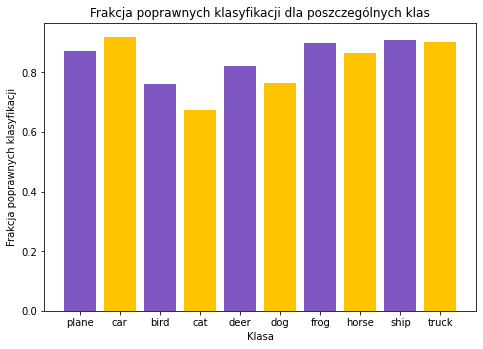

In [53]:
visualise_accuracy_by_class(classify_table)

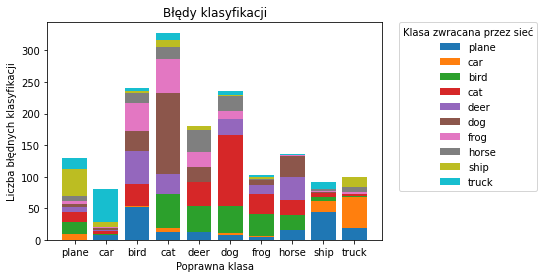

In [54]:
visualise_errors_by_class(classify_table)

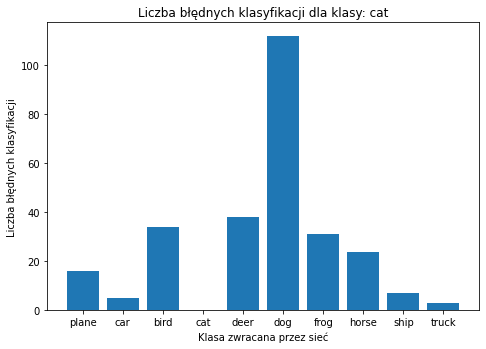

In [55]:
visualise_errors_for_class(classify_table, 3)